#UCB Algorithm

In UCB algorithm, we are only concerned with the upper bound, given that we are trying to find the arm with the highest reward rate.

At each given round of n trials, the reward UCB of all arms are represented by the following:


---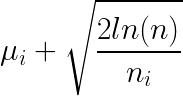


where mu_i represents the current reward return average of arm i at the current round, n represents the number of trials passed, and n_i represents the number of pulls given to arm i in the playthrough history.

The above formulation is simple but yet has several interesting implications as explained in the following:

The upper boundary is proportional to the squared root of ln(n), which means that when the experiment progresses, all arms have their upper boundaries increases by a factor of squared root of ln(n).
This upper boundary is inversely proportional to the squared root of n_i. The more times the specific arm has been engaged before in the past, the greater the confidence boundary reduces towards the point estimate. Thereafter, the UCB algorithm always picks the arm with the highest reward UCB as represented by the equation above.

A simple thought experiment to glean some intuition on how UCB algorithm incorporates exploration and exploitation.

The time complexity between the numerator and denominator provides a tension between exploration and exploitation. For any increase in n, the UCB increases only by logarithmic time, while for any increase in n_i, the UCB decreases by n_i. Thus, an arm that has not been explored as often as other arms will have a bigger UCB component. Depending on its current average mean, the overall UCB function representation of that specific arm may be greater than other arms with higher return but smaller components, and consequently enable that arm to be picked.


Below is the code for creation of the UCB algorithm setup and progressive updates of counts and values for arms.

Counts: Represent recorded times when arm was pulled.
Values: Represent the known mean reward. In the case of a Bernoulli arm, values represent the probability of reward which ranges from 0 to 1.

In [ ]:
import random
import numpy as np
import pandas as pd
import altair as alt

In [ ]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [ ]:
def simulation_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [ ]:
class UCB():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
    
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus
        return ucb_values.index(max(ucb_values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [ ]:
import random
import numpy as np
import pandas as pd

import math

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.4, 0.3, 0.5, 0.2, 0.1]
n_arms = len(means)
# Shuffling arms
#random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("ucb_results.tsv", "w+")

# Create 1 round of 5000 simulations
algo = UCB([], [])
algo.initialize(n_arms)
results = simulation_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("Simulation done for UCB algo, now check the result")

Best arm is 2
Simulation done for UCB algo, now check the result


In [ ]:

df = pd.read_csv("/content/ucb_results.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,simulation_num,step,chosen_arm,reward,cum_reward
0,1,1,0,1.0,1.0
1,1,2,1,0.0,1.0
2,1,3,2,0.0,1.0
3,1,4,3,0.0,1.0
4,1,5,4,0.0,1.0


In [ ]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [ ]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

In [ ]:
df_chose_count = df.loc[:,["step","chose_correct"]]

In [ ]:
df_chose_count

,step,chose_correct
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
1249995,246,1
1249996,247,1
1249997,248,1
1249998,249,0


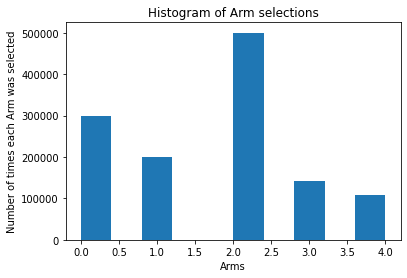

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df["chosen_arm"])
plt.title('Histogram of Arm selections')
plt.xlabel('Arms')
plt.ylabel('Number of times each Arm was selected')
plt.show()

In [ ]:

alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "UCB: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [0.4, 0.3, 0.5, 0.2, 0.1]",
)

alt.Chart(...)

The UCB algorithm has extreme fluctuations in its rate of choosing the best arm in the early phases of the experiment as shown by time steps between 0 to 20. This can be explained by the emphasis of exploration amongst all arms since the UCB components for all arms are much bigger at the start.

As the trial progresses, the UCB components becomes much smaller for all arms, and the UCB function representation of each arm converges towards the average reward mean of each arm. Thus, the arm with the higher mean becomes more distinguishable by the algorithm and becomes more frequently picked as the trial progresses. Thus, we observe that the rate of choosing the best arm does not seem to have a hard asymptote, but converges towards 0.5. The rate of convergence towards 0.5 slows down as it approaches 0.5, and the experiment time horizon was too short for us to observe any further convergence.

In [ ]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()


In [ ]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "UCB: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [0.4,0.3,0.5,0.2, 0.1]",
)

alt.Chart(...)

The cumulative reward plot of the UCB algorithm is comparable to the other algorithms. Although it does not do as well as the best of Epsilon Greedy where the cumulative reward was beyond 105, the UCB cumulative reward range is close to that range (around 100).

We also observe some form of curvature in the early phases of the trial, which can be corroborated by the extreme fluctuations we saw in the rate of choosing best arms. Likewise, when the experiment progresses, the algorithm can distinguish the best arm, and picks it with higher frequency, and the cumulative reward plot has a straight line gradient (which should approximate a value of 0.5 based on consistently choosing the best arm).

In [ ]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

In [ ]:

alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret")
).properties(
    title = "UCB: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [0.4, 0.3, 0.5, 0.2, 0.1]",
)

alt.Chart(...)

Based on the cumulative regret plots, we see that UCB has a cumulative regret of 32. It is also worst off compared to the Epsilon Greedy algorithm which had a range of 21 to 22. The cumulative regret line is also relatively straight, which means that the algorithm will continue to accumulate more regret with a longer time horizon.

##Summary
In this analysis of UCB algorithm, a learning takeaway is that for arms with closer means, the UCB algorithm does not seem to be as robust in terms of determining the best arm, for which Epsilon Greedy is more suitable.